In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import os


In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.0001


In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Make sure 'label' is a string
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="train/",
    x_col="filename",
    y_col="label",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    subset="training",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="train/",
    x_col="filename",
    y_col="label",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    subset="validation",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="test/",
    x_col="filename",
    y_col="label",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)


Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 824 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 824 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 206 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [5]:
def build_mobilenet(base_model, name):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(5, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions, name=name)
    model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [6]:
mobilenets = {
    "MobileNetV1": MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "MobileNetV3": MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

histories = {}

for name, base in mobilenets.items():
    print(f"\nTraining {name}...")
    model = build_mobilenet(base, name)
    history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
    histories[name] = history


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Training MobileNetV1...


c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

C:\Users\anand\AppData\Local\Temp\ipykernel_25688\948704841.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


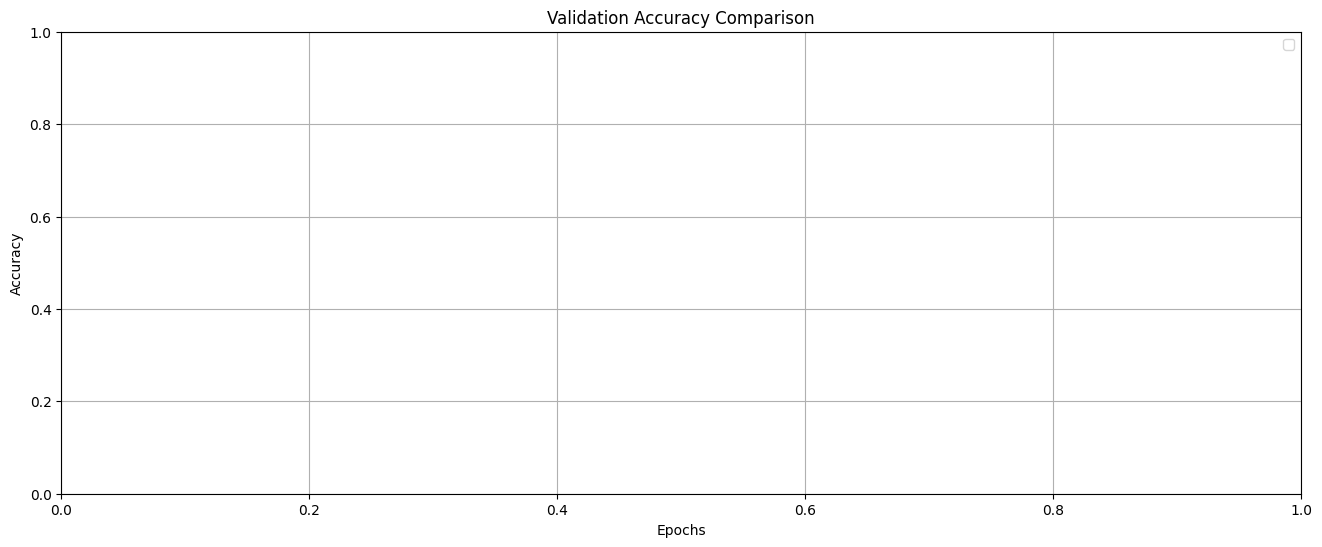

In [7]:
def plot_histories(histories):
    plt.figure(figsize=(16,6))

    for name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Accuracy')
    
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histories(histories)


In [ ]:
for name, base in mobilenets.items():
    model = build_mobilenet(base, name)
    model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
    loss, acc = model.evaluate(test_gen, verbose=0)
    print(f"{name} Test Accuracy: {acc:.4f}")
